### IMPORTING PACKAGES

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import DataFrame
import pandas as pd
from pyspark.sql.functions import (
    min, max, year, month, col, isnan, isnull, when, count, countDistinct, 
    round, desc, sum as sum_, mean, stddev, variance, skewness, kurtosis, 
    explode, split, regexp_replace, to_timestamp, to_date, lit, datediff, current_date
)
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
from pyspark.sql.functions import create_map, lit
from itertools import chain
from pyspark.sql.functions import avg as F_avg
from pyspark.sql.functions import sum as F_sum
from pyspark.sql.functions import count as F_count
from pyspark.sql.functions import col, round as F_round
from pyspark.sql.functions import log1p 
import seaborn as sns
from pyspark.ml.stat import Correlation
import numpy as np
import pylab as pl
from pyspark.ml.linalg import Vectors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from sklearn.cluster import KMeans
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Changing the directory in the Colab notebook to a specific location within the Google Drive
%cd C:\Users\june3\OneDrive\Desktop\my_output_result\

C:\Users\june3\OneDrive\Desktop\my_output_result


### CREATE SPARK SESSION

In [3]:
# Step 1: Create a SparkSession
spark = SparkSession.builder \
    .appName("K-means on SDWA") \
    .getOrCreate()

### LOADING .CSV FILES AND READING INTO SPARK DATAFRAMES

In [4]:
# Step 2: Read all CSV files into a list of Spark DataFrames
df = spark.read.csv("eda_analysis.csv", header=True, inferSchema=True)

In [5]:
def get_missing_values(df, dataframe_name):
    # Compute missing values for each column
    missing_df = df.select([
        count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns
    ])
    
    # Convert to Pandas for better formatting
    missing = missing_df.toPandas().transpose().reset_index()
    missing.columns = ['Column', 'Missing_Count']
    
    # Display the missing values
    print(f"--- Missing Values in {dataframe_name} ---")
    print(missing.to_markdown(index=False))
    print("\n")

In [6]:
def get_summary_statistics(df, dataframe_name):
    # Compute summary statistics
    summary = df.describe().toPandas().set_index('summary').transpose()
    
    # Rename the index to the dataframe name for clarity
    summary.index.name = 'Column'
    
    # Display the summary statistics
    print(f"--- Summary Statistics for {dataframe_name} ---")
    print(summary.to_markdown())
    print("\n")

In [7]:
print(f" Dataframe 1: rows: {df.count()}, columns: {len(df.columns)} ")

 Dataframe 1: rows: 43073, columns: 29 


In [8]:
cat_vars = ["PWS_ACTIVITY_CODE", 
            "IS_SCHOOL_OR_DAYCARE_IND",
            "SOURCE_WATER_PROTECTION_CODE", 
            "OUTSTANDING_PERFORMER",
            "MANAGEMENT_OPS_EVAL_CODE",
            "SOURCE_WATER_EVAL_CODE",
            "SECURITY_EVAL_CODE",
            "PUMPS_EVAL_CODE",
            "OTHER_EVAL_CODE",
            "COMPLIANCE_EVAL_CODE",
            "DATA_VERIFICATION_EVAL_CODE",
            "TREATMENT_EVAL_CODE",
            "FINISHED_WATER_STOR_EVAL_CODE",
            "DISTRIBUTION_EVAL_CODE",
            "FINANCIAL_EVAL_CODE",
            "VIOLATION_CATEGORY_CODE",
            "IS_HEALTH_BASED_IND",
            "IS_MAJOR_VIOL_IND",
            "VIOLATION_STATUS",
            "ENF_ACTION_CATEGORY",
           "COMPLIANCE_STATUS"]

In [9]:
num_vars = ["TOTAL_POPULATION_SERVED_COUNT_LOG",
            "TOTAL_SERVICE_CONNECTIONS_COUNT_LOG",
            "VIOL_MEASURE_LOG",
            "TOTAL_VIOLATIONS_LOG",
            "AVG_VIOLATION_DURATION_DAYS_LOG",
            "OPEN_VIOLATIONS_COUNT_LOG",
            "TOTAL_LATE_COMPLIANT_ACTIONS_LOG"
           ]

In [10]:
get_missing_values(df,  "DATAFRAME")

--- Missing Values in DATAFRAME ---
| Column                              |   Missing_Count |
|:------------------------------------|----------------:|
| PWSID                               |               0 |
| PWS_ACTIVITY_CODE                   |               0 |
| IS_SCHOOL_OR_DAYCARE_IND            |               0 |
| SOURCE_WATER_PROTECTION_CODE        |               0 |
| OUTSTANDING_PERFORMER               |               0 |
| MANAGEMENT_OPS_EVAL_CODE            |               0 |
| SOURCE_WATER_EVAL_CODE              |               0 |
| SECURITY_EVAL_CODE                  |               0 |
| PUMPS_EVAL_CODE                     |               0 |
| OTHER_EVAL_CODE                     |               0 |
| COMPLIANCE_EVAL_CODE                |               0 |
| DATA_VERIFICATION_EVAL_CODE         |               0 |
| TREATMENT_EVAL_CODE                 |               0 |
| FINISHED_WATER_STOR_EVAL_CODE       |               0 |
| DISTRIBUTION_EVAL_CODE            

In [11]:
# Pipeline stages
stages = []

# Step 1: Process categorical variables
for col in cat_vars:
    # StringIndexer for categorical variable
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    stages.append(indexer)

    # OneHotEncoder for indexed variable
    encoder = OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded")
    stages.append(encoder)

# Step 2: Combine all encoded categorical and numerical columns using VectorAssembler
# Collect encoded categorical columns and add numerical columns
assembled_input_cols = [f"{col}_encoded" for col in cat_vars] + num_vars

assembler = VectorAssembler(inputCols=assembled_input_cols, outputCol="features")
stages.append(assembler)

# Step 3: Create the pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the data
final_df = pipeline.fit(df).transform(df)

# final_df have a "features" column with all categorical and numerical variables combined


In [12]:
final_df.printSchema()

root
 |-- PWSID: string (nullable = true)
 |-- PWS_ACTIVITY_CODE: string (nullable = true)
 |-- IS_SCHOOL_OR_DAYCARE_IND: string (nullable = true)
 |-- SOURCE_WATER_PROTECTION_CODE: string (nullable = true)
 |-- OUTSTANDING_PERFORMER: string (nullable = true)
 |-- MANAGEMENT_OPS_EVAL_CODE: string (nullable = true)
 |-- SOURCE_WATER_EVAL_CODE: string (nullable = true)
 |-- SECURITY_EVAL_CODE: string (nullable = true)
 |-- PUMPS_EVAL_CODE: string (nullable = true)
 |-- OTHER_EVAL_CODE: string (nullable = true)
 |-- COMPLIANCE_EVAL_CODE: string (nullable = true)
 |-- DATA_VERIFICATION_EVAL_CODE: string (nullable = true)
 |-- TREATMENT_EVAL_CODE: string (nullable = true)
 |-- FINISHED_WATER_STOR_EVAL_CODE: string (nullable = true)
 |-- DISTRIBUTION_EVAL_CODE: string (nullable = true)
 |-- FINANCIAL_EVAL_CODE: string (nullable = true)
 |-- VIOLATION_CATEGORY_CODE: string (nullable = true)
 |-- IS_HEALTH_BASED_IND: string (nullable = true)
 |-- IS_MAJOR_VIOL_IND: string (nullable = true)
 |-

In [13]:
# Standardize the feature vector
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(final_df)
scaled_data = scaler_model.transform(final_df)

In [14]:
scaled_data.cache()

DataFrame[PWSID: string, PWS_ACTIVITY_CODE: string, IS_SCHOOL_OR_DAYCARE_IND: string, SOURCE_WATER_PROTECTION_CODE: string, OUTSTANDING_PERFORMER: string, MANAGEMENT_OPS_EVAL_CODE: string, SOURCE_WATER_EVAL_CODE: string, SECURITY_EVAL_CODE: string, PUMPS_EVAL_CODE: string, OTHER_EVAL_CODE: string, COMPLIANCE_EVAL_CODE: string, DATA_VERIFICATION_EVAL_CODE: string, TREATMENT_EVAL_CODE: string, FINISHED_WATER_STOR_EVAL_CODE: string, DISTRIBUTION_EVAL_CODE: string, FINANCIAL_EVAL_CODE: string, VIOLATION_CATEGORY_CODE: string, IS_HEALTH_BASED_IND: string, IS_MAJOR_VIOL_IND: string, VIOLATION_STATUS: string, ENF_ACTION_CATEGORY: string, COMPLIANCE_STATUS: string, TOTAL_POPULATION_SERVED_COUNT_LOG: double, TOTAL_SERVICE_CONNECTIONS_COUNT_LOG: double, VIOL_MEASURE_LOG: double, TOTAL_VIOLATIONS_LOG: double, AVG_VIOLATION_DURATION_DAYS_LOG: double, OPEN_VIOLATIONS_COUNT_LOG: double, TOTAL_LATE_COMPLIANT_ACTIONS_LOG: double, PWS_ACTIVITY_CODE_indexed: double, PWS_ACTIVITY_CODE_encoded: vector, IS

In [15]:
# Extract 'features' column from PySpark DataFrame and convert it to Pandas
pandas_df = scaled_data.select('scaled_features').toPandas()

# Convert the PySpark vector to a NumPy array that can be used in sklearn
X = np.array(pandas_df['scaled_features'].tolist())

In [16]:
df_scaled = scaled_data.toPandas()

In [17]:
# Define range of number of clusters for KMeans
n_clusters_values = np.arange(2, 11, 1)  # Trying 2 to 10 clusters
results = []

for n_clusters in n_clusters_values:
    # Initialize and fit KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Check if there are at least 2 clusters
    unique_labels = set(labels)
    num_clusters = len(unique_labels)
    
    if num_clusters > 1:
        # Filter out noise points (if any, or just calculate metrics for valid clusters)
        clustered_points = X
        valid_labels = labels
        
        # Calculate metrics
        silhouette = silhouette_score(clustered_points, valid_labels)
        davies_bouldin = davies_bouldin_score(clustered_points, valid_labels)
        calinski_harabasz = calinski_harabasz_score(clustered_points, valid_labels)
        
        # Store results
        results.append([n_clusters, silhouette, davies_bouldin, calinski_harabasz])
    else:
        # Store results for the case where there are insufficient clusters
        results.append([n_clusters, None, None, None])

# Create a DataFrame for better visualization
df_results = pd.DataFrame(results, columns=["Number of Clusters", "Silhouette Score", "Davies-Bouldin Score", "Calinski-Harabasz Score"])

In [19]:
df_results

,Number of Clusters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.188058,1.573361,7199.624724
1,3,0.232875,1.382103,7465.788314
2,4,0.249070,2.016873,6265.193466
3,5,0.159385,2.193434,5460.495107
4,6,0.156173,2.369992,4893.668278
5,7,0.149919,2.340006,4443.248946
6,8,0.145818,2.324859,4007.501030
7,9,0.142511,2.356410,3731.005448
8,10,0.150593,2.240781,3473.036571


In [20]:
# Define range of number of clusters
n_clusters_range = range(2, 20)

# Initialize lists to store the metrics
wcss = []  # For the Elbow Plot
silhouette_scores = []  # For the Silhouette Plot

# Loop through each number of clusters
for n_clusters in n_clusters_range:
    # Initialize and fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    
    # Calculate WCSS (inertia)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score only if we have more than one cluster
    if n_clusters > 1:
        silhouette_avg = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan)  # Not defined for single cluster


Elbow Plot

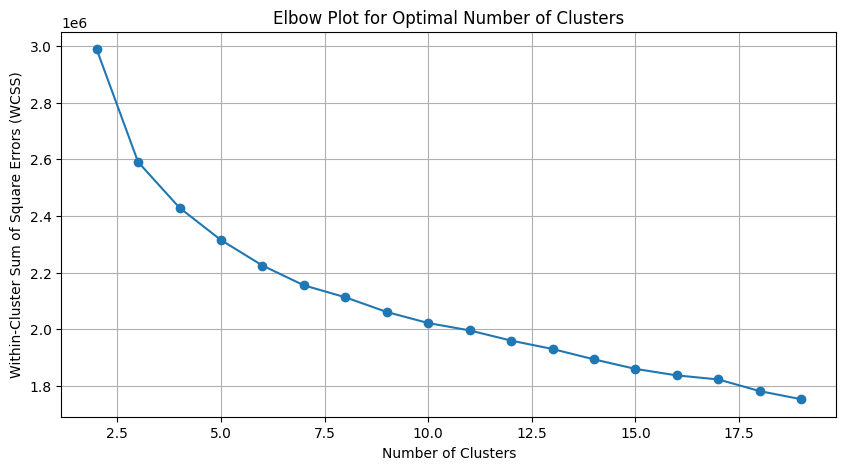

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, wcss, marker='o')
plt.title("Elbow Plot for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Within-Cluster Sum of Square Errors (WCSS)")
plt.grid(True)
plt.show()

Silhoutte Plot

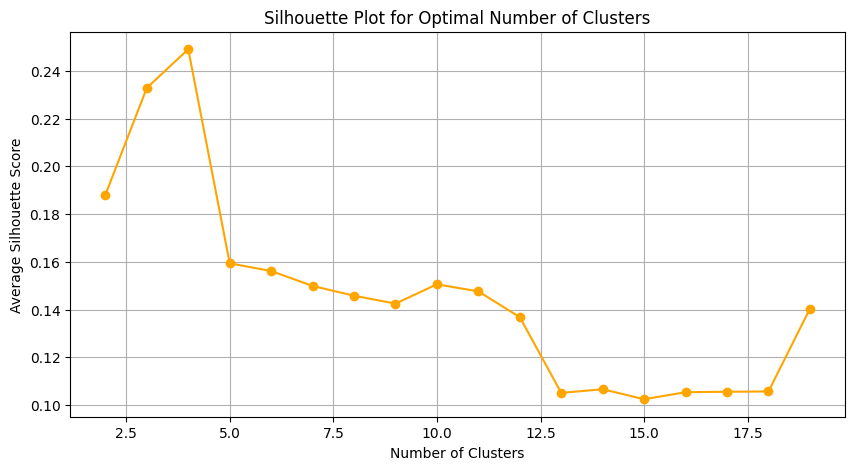

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Plot for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

In [23]:
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
df_scaled['Cluster'] = kmeans.fit_predict(X)

In [24]:
# Cluster distribution
cluster_counts = df_scaled['Cluster'].value_counts()
cluster_percentages = (df_scaled['Cluster'].value_counts(normalize=True) * 100).round(2)

# Summary DataFrame
cluster_summary = pd.DataFrame({
    'Cluster Count': cluster_counts,
    'Cluster Percentage (%)': cluster_percentages
})

In [25]:
cluster_summary

,Cluster Count,Cluster Percentage (%)
Cluster,,
2,28581,66.35
1,8283,19.23
3,3584,8.32
0,2625,6.09


In [26]:
# Apply KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
df_scaled['Cluster_5'] = kmeans.fit_predict(X)

In [27]:
# Cluster distribution
cluster_counts = df_scaled['Cluster_5'].value_counts()
cluster_percentages = (df_scaled['Cluster_5'].value_counts(normalize=True) * 100).round(2)

# Summary DataFrame
cluster_summary = pd.DataFrame({
    'Cluster Count': cluster_counts,
    'Cluster Percentage (%)': cluster_percentages
})

In [28]:
cluster_summary

,Cluster Count,Cluster Percentage (%)
Cluster_5,,
3,21950,50.96
1,8155,18.93
0,7296,16.94
2,3051,7.08
4,2621,6.09


In [36]:
# Set index=True to save the DataFrame index
df_scaled.to_csv('C:/Users/june3/OneDrive/Desktop/my_output_result/km5.csv', index=False) 

In [27]:
spark.stop()